# **Integrated Classification with MMoCHi**

**Author:** Daniel Caron

**In this notebook, we will use MMoCHi for cell type annotation of CITE-Seq data. First, we will batch-integrate Antibody-Derived Tag (ADT) expression across multiple datasets. Then, we will use unsupervised analysis to explore our data. Lastly, we will design a simple MMoCHi hierarchy, perform high-confidence thresholding, and apply it to predict cell types!**

## MMoCHi is a useful tool for:
    1. Identifying predefined cell types or states 
    2. Labeling cells by lineage when other sources of variation dominate 
       in unsupervised analyses
    3. Distinguishing cell types that don't form discrete clusters
    4. Integrating cell type identification across samples

## **Import Packages**

In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['legend.frameon'] = 'False'
plt.show() # so that the first plot will respect rcParams

import mmochi as mmc
import os

# Make the directory if not being run in the docs folder
if not os.path.isdir('data'):
    os.mkdir('data')

## **Optional step: Enable logging to file, and set defaults**

All printed statements (as well as some additional details) can be written to a log file for later reference.

In [2]:
mmc.log_to_file('integrated_classification')

Additionally, the default location of batch labels and the location of multimodal data in the `.obsm` in the can be set globally, for use by many MMoCHi functions.

In [3]:
mmc.DATA_KEY = 'landmark_protein'
mmc.BATCH_KEY = 'batch'

## **Downloading and preprocessing the data**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Often, we need a unified annotation system for multiple batches or datasets. Here, we will train a MMoCHi classifier across multiple 10X Genomics sequencing runs (pbmc_10k_protein_v3 and 5k_pbmc_protein_v3). We have built a helper function (`mmc.utils.preprocess_adatas()`) to assist with normalization and formatting.

More details on the expected inputs to MMoCHi can be found in the [Input/Output Specifications](Input_Output_Specs.md).

In [4]:
batches = ['pbmc_10k_protein_v3','5k_pbmc_protein_v3']
files = ['data/pbmc_10k_protein_v3.h5','data/5k_pbmc_protein_v3.h5']
urls = ['http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5',
        'http://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5']
adatas = mmc.utils.preprocess_adatas(files,
                                     backup_urls = urls, log_CP_ADT=1e3, log_CP_GEX=1e4)
adata = anndata.concat(adatas, merge='first', keys=batches,
                       label='batch', index_unique='_')

## **Normalizing ADTs - Landmark Registration**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Because of variation in antibody staining and background signal and variation in sequencing depth, CITE-Seq data requires careful integration. Here, we use landmark registration to integrate ADT expression across datasets. First, our function calculates the the expression probability density for each marker. Then it identifies landmarks (peaks) in these distributions and aligns them across batches. This tool works similarly to [ADTnorm](https://github.com/yezhengSTAT/ADTnorm/). For more details on using our in-house function, see the [Landmark Registration tutorial](Landmark_Registration.ipynb).

Prior to classification, we should also remove any isotype controls, or other ADTs whose expression we expect to be uninformative for cell type discrimination.

In [5]:
adata.obsm['protein'].drop(['IgG2a_control','IgG2b_control','IgG1_control'], axis=1, inplace=True)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To make the landmark registration calculation reproducible we fix the peak alignment for all markers to arbitrary values. The in-house function automatically aligns negative peaks to 1 and positive peaks to 3. When using other landmark registration functions (e.g. [ADTnorm](https://github.com/yezhengSTAT/ADTnorm/)), fixed targets must be explicitly defined.

In [6]:
adata = mmc.landmark_register_adts(adata, single_peaks=['CD25'], batch_key='batch')

Running with batch batch


  0%|          | 0/2 [00:00<?, ?it/s]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Once landmark registration is performed, let's look at how it affected the expression distribution for each ADT. The ADT expression distribution (`'protein'`) and the landmark-registered distributions (`'landmark protein'`) are shown side-by-side for each marker on a 10% subsample of the dataset. Peaks detected are highlighted by small black bars. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, we want to pay close attention, checking for any populations where peak detection may have failed. Although this can be quite tedious, especially with large CITE-Seq panels and many batches, manual adjustment of peak detection will have a major effect on the quality of the integration. See the [Landmark Registration tutorial](Landmark_Registration.ipynb) for more information on this process.

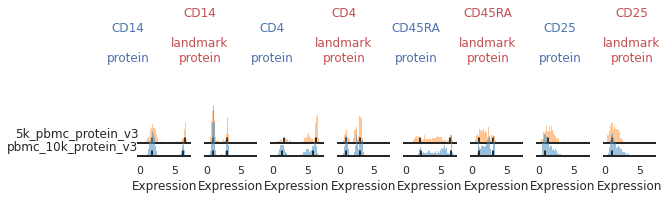

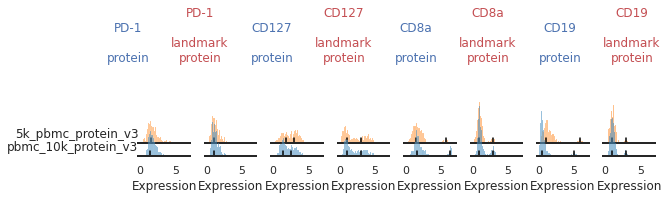

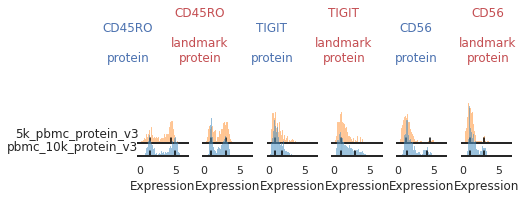

In [7]:
mmc.stacked_density_plots(adata, adata.obsm['protein'].columns[0:4], batch_key='batch', subsample = .1, height=1, aspect=1)
mmc.stacked_density_plots(adata, adata.obsm['protein'].columns[5:9], batch_key='batch', subsample = .1, height=1, aspect=1)
mmc.stacked_density_plots(adata, adata.obsm['protein'].columns[10:13], batch_key='batch', subsample = .1, height=1, aspect=1)

<div class="alert alert-warning">
    
**Check through individual histograms as needed!** 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With this plotting function, it can be really hard to see small positive populations or nuances in the distributions. For any markers whose distribution looks suspsicious or unclear here, we have provided other plotting functions (described in the [Landmark Registration tutorial](Landmark_Registration.ipynb)) to check it more carefully. Careful inspection here and on UMAPs can also be informative for choosing markers for high-confidence thresholding.

</div>

## **Exploring the data**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Prior to cell type classification, it's important to get familiar with your dataset! This will help inform which cell types to include in your hierarchy. To do this, let's first run through a simple pipeline for integration, UMAP generation, and clustering. More details on unsupervised analysis using scanpy and Harmony integration can be found [here](https://scanpy.readthedocs.io/en/stable/tutorials.html) and [here](https://portals.broadinstitute.org/harmony/articles/quickstart.html).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since these processes are stochastic, we have provided the UMAP coordinates and Leiden clusters as files to load in. If you are running this notebook from the docs directory, the following code should load them in. If not, this will run a simple pipeline for unsupervised analysis and Harmony integration.

In [8]:
if os.path.isfile('data/Integrated_Classification_X_umap.txt') and os.path.isfile('data/Integrated_Classification_leiden.csv'):
    adata.obsm['X_umap'] = np.loadtxt('data/Integrated_Classification_X_umap.txt')
    adata.obs['leiden'] = pd.read_csv('data/Integrated_Classification_leiden.csv', index_col=0).astype(str).astype('category')
else:
    print('No pre-made files found, performing new unsupervised analysis.')
    sc.pp.highly_variable_genes(adata)
    sc.pp.pca(adata)
    sc.external.pp.harmony_integrate(adata, adjusted_basis='X_pca', key='batch',
                                     verbose=False, max_iter_harmony=20)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=2)
    np.savetxt('data/Integrated_Classification_X_umap.txt', adata.obsm['X_umap'])
    adata.obs['leiden'].to_csv('data/Integrated_Classification_leiden.csv')

<div class="alert alert-info">
    
**Tip — Multimodal Unsupervised Analysis**
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, for simplicity, we are only performing UMAP analysis and clustering on the gene expression (GEX). To allow for detection of populations identified exclusively by surface protein expression, you can repeat this with ADT data. Other tools, such as [totalVI](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/totalVI.html), can embed both the GEX and ADT data simultaneously, and can also be explored!
</div>

Let's first plot the batches and Leiden clusters to evaluate the integration and clustering:

... storing 'leiden' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


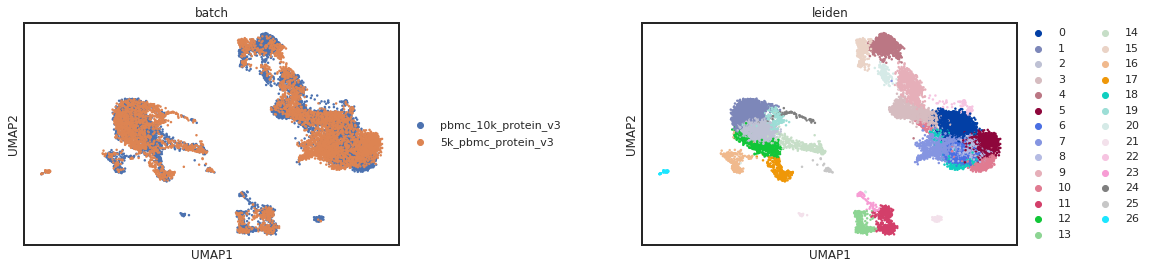

In [9]:
sc.pl.umap(adata, color=['batch','leiden'], s=25, sort_order=False, wspace =.5)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's take a look at some marker genes and proteins for various immune cell subsets. Performing this cursory unsupervised analysis is critical, as it will help you identify any quality control issues, unexpected cell types, or novel cell states. This can also be a helpful step to validate that the markers you plan to use for cell type identification are well-expressed in the data set.

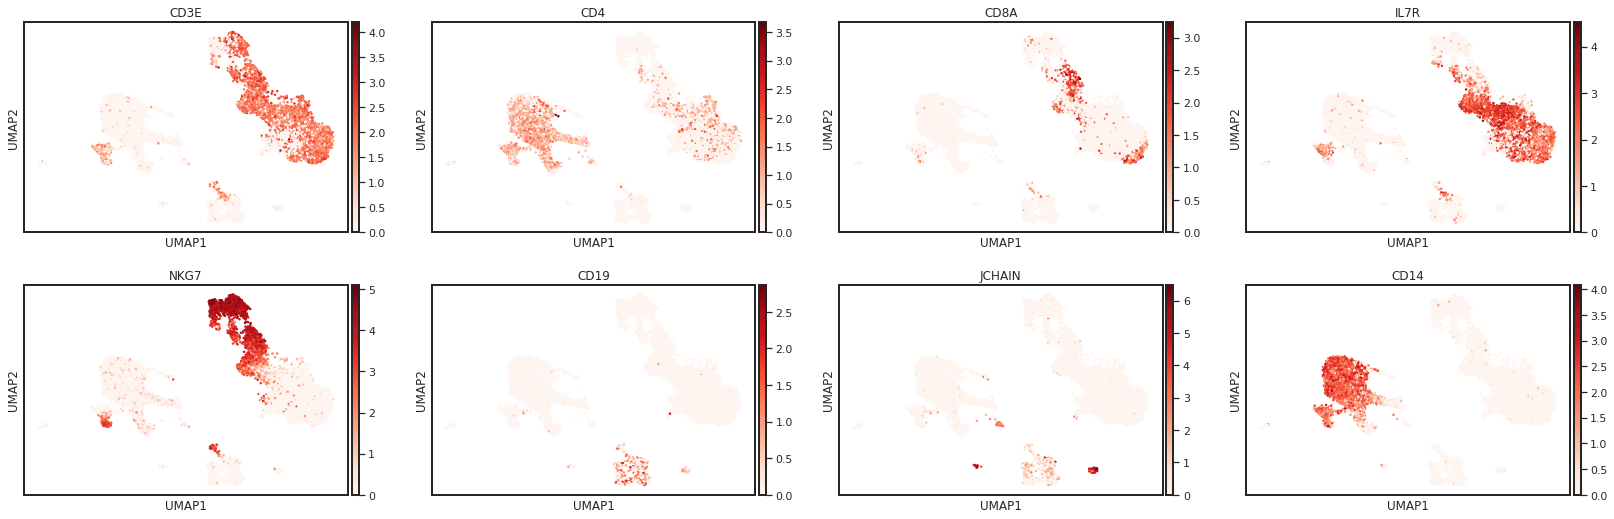

In [10]:
sc.pl.umap(adata, color=['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'],
           s=25, sort_order=False, cmap='Reds')

One way to plot protein expression using scanpy's UMAP functions is to create an AnnData object with ADT expression stored in the `.X`

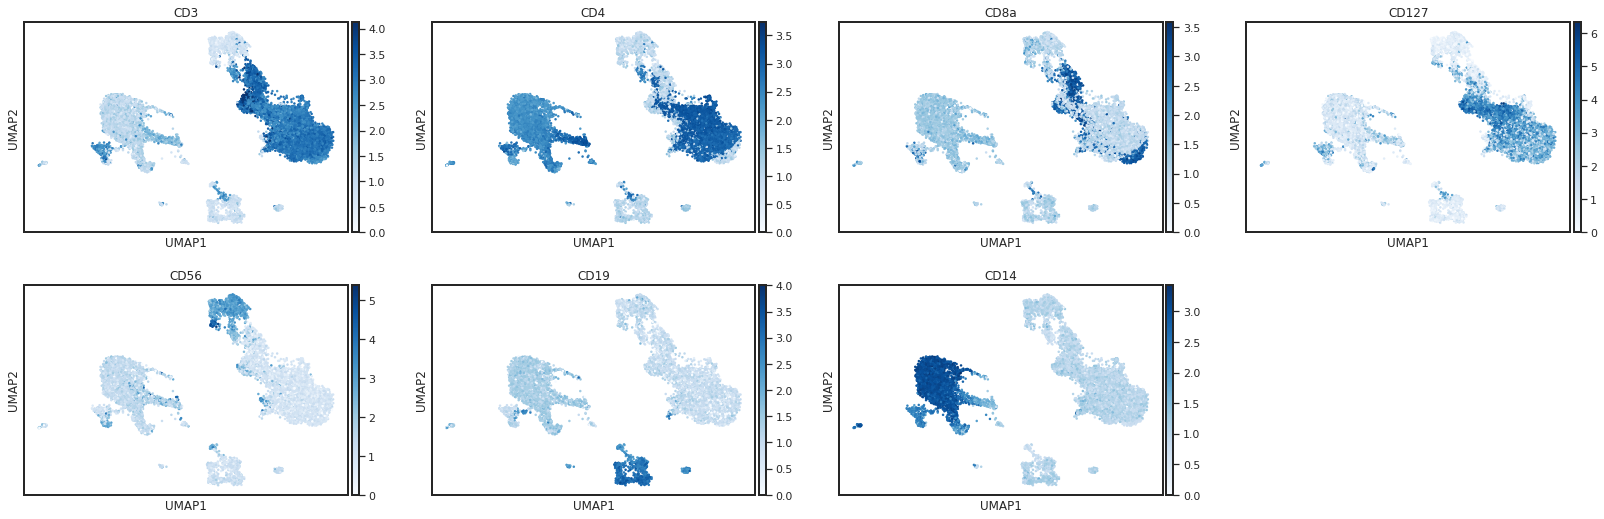

In [11]:
protein_adata = anndata.AnnData(adata.obsm['landmark_protein'], adata.obs.copy(), dtype=float)
protein_adata.obsm['X_umap'] = adata.obsm['X_umap'].copy()
sc.pl.umap(protein_adata, color=['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'],
           s=25, sort_order=False, cmap='Blues')

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, we can identify a cluster of events with expression of CD3 and CD19 (Leiden cluster 23). These are likely T/B cell doublets which were not removed during our QC steps. We could either delete these events from our object, or label them for removal prior to classification by creating a new columns in the `.obs`.

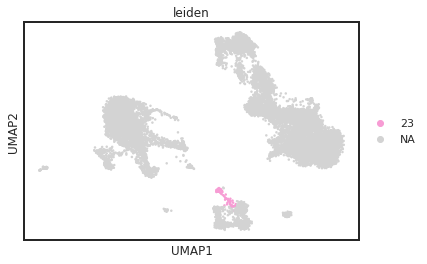

In [12]:
sc.pl.umap(adata,color=['leiden',], s=25, sort_order=False, wspace =.5, groups=['23'])

Cutoff layers are designed to handle string categoricals, thus we convert the boolean mask to strings.

In [13]:
adata.obs['T_B doublets'] = adata.obs.leiden.isin(['23']).astype(str)

<div class="alert alert-warning">

**Check carefully!**
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; It's important that any significant amounts of contaminants or unexpected cell types are removed prior to classification. Although MMoCHi has built-in steps for cleaning up data used for training, if large amounts of unexpected cells are labeled by high-confidence thresholding, the classifier may learn incorrect cell type representations or act in potentially unexpected ways.
</div>


## **Define the hierarchy**
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MMoCHi classification is built around the `mmc.Hierarchy` class, which supports setting up the classification scheme and stores the classifiers. Here, we define a hierarchy with default settings for the training conditions then add classification levels to it. Distinguishing these populations in a hierarchy helps prevent the algorithm from confusing cell types that are only very distantly related.
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Each classification level classifies events into two or more subsets, which are defined by expression of specified markers. These expression-based definitions are used to find representative high-confidence events for training of the random forest. Some classification nodes, which are deemed 'cutoffs', can be used to manually split populations of interest, rather than training a random forest. Cutoffs can be applied using a categorical column in the <code>.obs</code> or by the thresholding marker expression. For more information, see the [Hierarchy Design tutorial](./Hierarchy_Design.ipynb).

In [14]:
h= mmc.Hierarchy(default_min_events=15, default_class_weight = 'balanced')

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To add a classification level, you define a name, parent node (the root node in a Hierarchy object is `'All'`), and markers. Negative and positive markers for each population can be defined, as well as more complex boolean gating rules. Each subset's marker expression can be defined either by lists of 'pos', 'neg', or 'any', where a subset's definitions are listed in the same order as its classification level's markers, or as a dictionary, which is interpreted by the `mmc.hierarchy.hc_defs` function, allowing for more human-readable gating strategies. See the docs or the [Hierarchy Design tutorial](./Hierarchy_Design.ipynb) for more details on possible options. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, we add a cutoff classification node for junk removal, to remove a leiden cluster we have previously identified as potential doublets. Then, we add a broad lineages classifier to segregate lymphoid and myeloid cells. We continue on to further segregate lymphocyte subsets. As demonstrated, high-confidence thresholding can use both gene and protein markers.

In [15]:
h.add_classification('Removal', 'All', ['T_B doublets'], is_cutoff=True) 
h.add_subset('Potential Doublets', 'Removal', ['True'])
h.add_subset('To classify', 'Removal', ['False'])

In [16]:
h.add_classification('Broad Lineages', 'To classify', ['CD14','CD33','MARCO','MERTK','CD3','CD19','JCHAIN','LILRA4']) 
h.add_subset('Lymphocyte', 'Broad Lineages', dict(neg=['CD14','CD33','MARCO','MERTK'], any_of=['CD3','CD19','JCHAIN'], n=1))
h.add_subset('Myelocyte', 'Broad Lineages', dict(any_of=['CD14','CD33','MARCO','MERTK','LILRA4'], n=1, neg=['CD3','CD19']))

In [17]:
h.add_classification('Lymphoid', 'Lymphocyte', ['CD3','CD19','CD56','CD127','JCHAIN'])           
h.add_subset('T cell', 'Lymphoid', dict(pos=['CD3','CD127'], neg=['CD19','JCHAIN']))
h.add_subset('B cell', 'Lymphoid', dict(any_of=['CD19'], neg=['CD3','CD127','JCHAIN']))
h.add_subset('Plasma cell', 'Lymphoid', dict(any_of=['JCHAIN'], neg=['CD3','CD127']))
h.add_subset('NK_ILC', 'Lymphoid', dict(neg=['CD19','JCHAIN','CD3'], any_of=['CD127','CD56']))

In [18]:
h.add_classification('NK_ILC Subsets', 'NK_ILC', ['CD127','EOMES'])
h.add_subset('NK', 'NK_ILC Subsets', dict(neg=['CD127',], pos=['EOMES',]))
h.add_subset('ILC', 'NK_ILC Subsets', dict(pos=['CD127',], neg=['EOMES',]))

In [19]:
h.add_classification('CD4_CD8', 'T cell', ['CD4','CD8a','CD4_gex','CD8A_gex'], clf_kwargs=dict(max_features=.1))
h.add_subset('CD4 T cell', 'CD4_CD8', dict(pos=['CD4',], neg=['CD8a','CD8A_gex']))
h.add_subset('CD8 T cell', 'CD4_CD8', dict(neg=['CD4','CD4_gex'], pos=['CD8a','CD8A_gex']))

<div class="alert alert-info">

**Tip — Classifier kwargs** 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To optimize cell classification, sometimes the default random forest needs parameter adjustment. For example, here only a few markers can be used to reliably distinguish CD4 and CD8 T cells, so the random forest may need to be tuned for a better fit. The hierarchy supports this by allowing each classification level to pass their own kwargs to `sklearn.ensemble.RandomForestClassifier`. Here, we increase max_features to decrease the randomness of the forest. This comes with the risk of increasing overfitting. Read more about kwarg options [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
</div>

Now that the hierarchy has been defined, we can take a look at it! This display function is great for visualizing the classification levels (rectangles) and subset definitions (ovals).

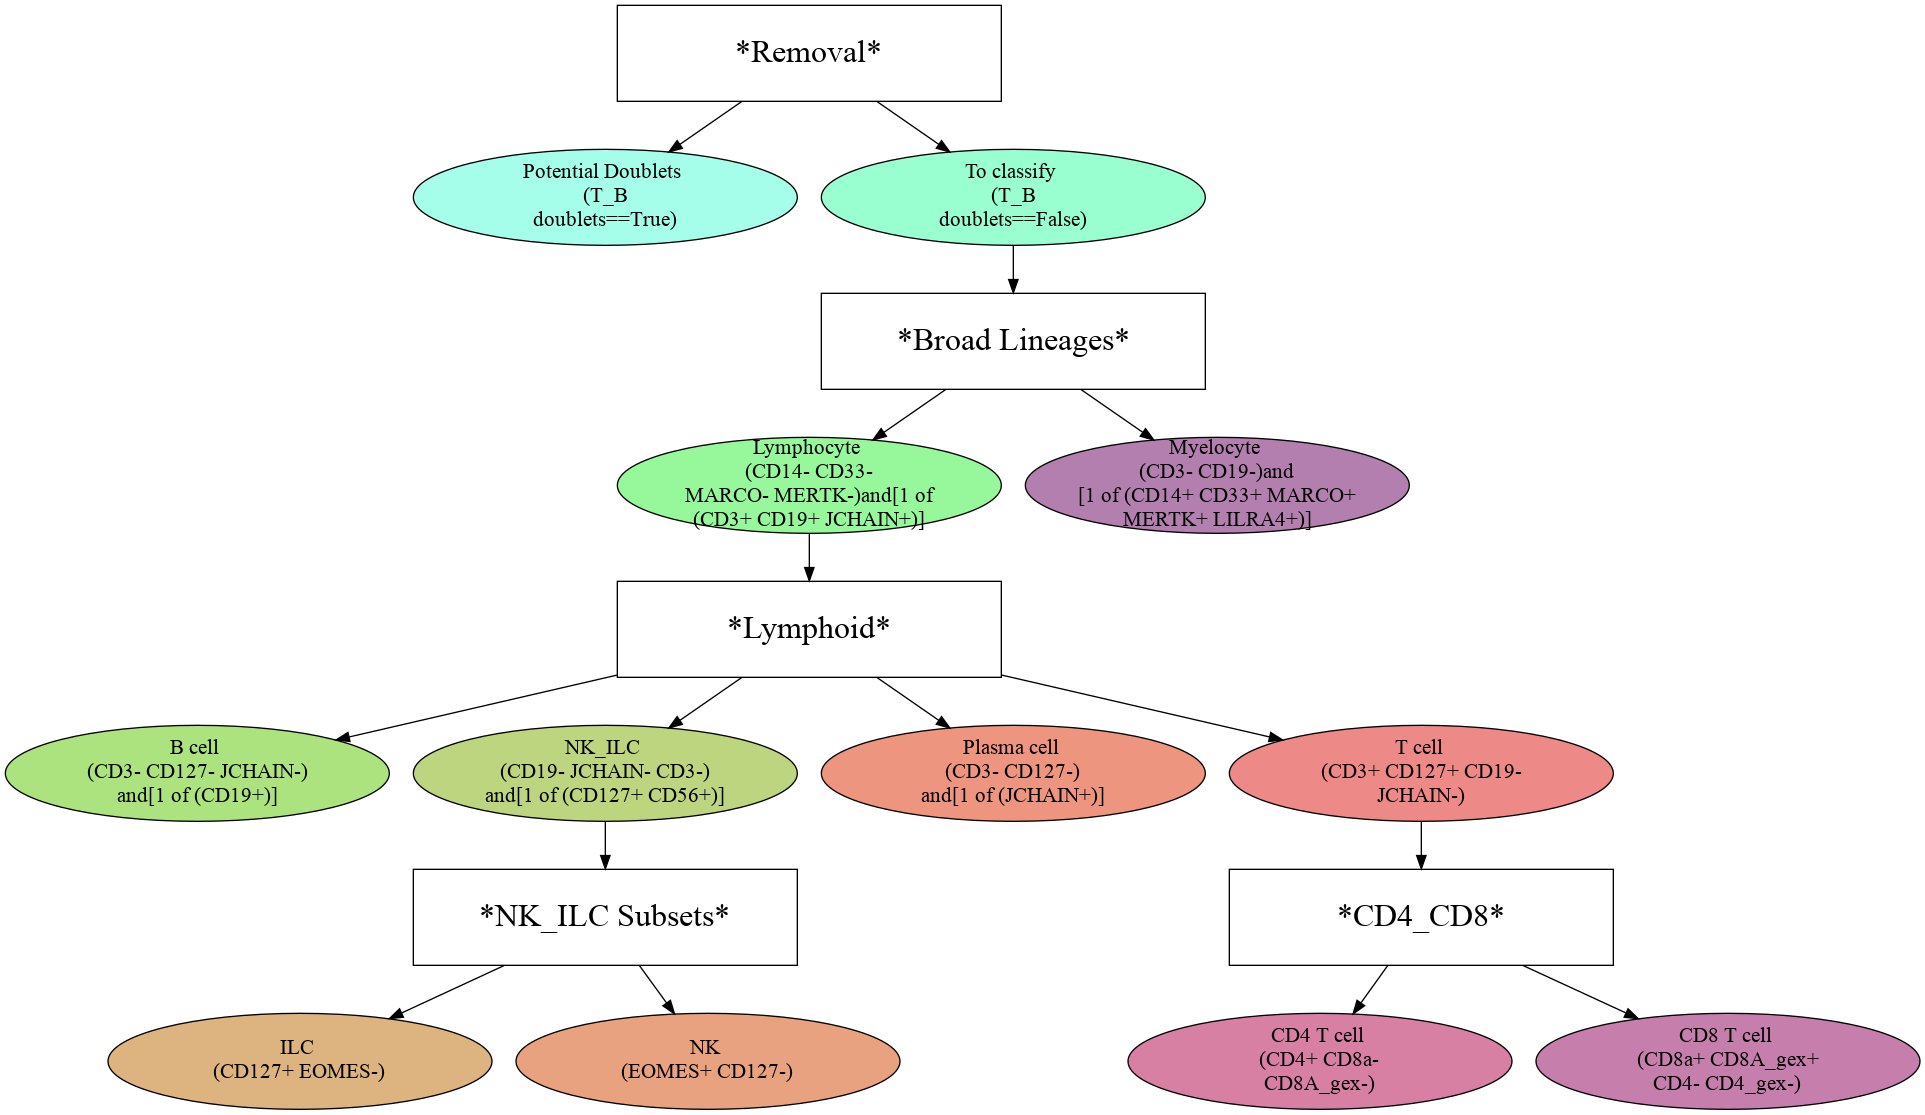

In [20]:
h.color_dict(True, rot=1, hue=3, mode='DEPTH')
h.display(True)

## **Run thresholding**
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In order to define high-confidence data for training the classifier, we must identify positive and negative populations for each marker defined in the hierarchy. The `mmc.Hierarchy` object stores thresholds for each marker, which can be saved and loaded from a .csv for convenience. 

In [21]:
h.reset_thresholds()
if os.path.isfile('data/integrated_thresholds.csv'):
    h.load_thresholds('data/integrated_thresholds.csv')
else:
    print('File not found, generate thresholds yourself using h.run_all_thresholds with `limit=None`!')

Loaded thresholds.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;High-confidence thresholding of each marker used in the hierarchy is the most critical step of MMoCHi classification, and often will require a few rounds to fine-tune. MMoCHi will attempt to predict thresholds from a Gaussian mixture model, but these predictions are far from perfect. Here, we have performed thresholding ahead of time, and loaded those in.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This plotting function allows you to visualize and alter the thresholds we have manually set. As many of these markers have high rates of dropout, events with 0 expression of a marker have been hidden. The percent of the dataset with non-zero expression of a marker is displayed above each plot as an aid. Thresholding can be performed separately for each batch or globally (useful when thresholding batch-integrated expression data). There are many options for which markers to display and in what order. Various modes are detailed in the docstring. Using the 'fancy' keyword in any mode name activates iPython widgets!  For an example of the widget display, see: [here](_static/ThresholdingWidgetsExample.png)!

For more details on the thresholding process, see the [High-Confidence Thresholding tutorial](High_Confidence_Thresholding.ipynb). 

Here, let's just observe the thresholding for a few markers:

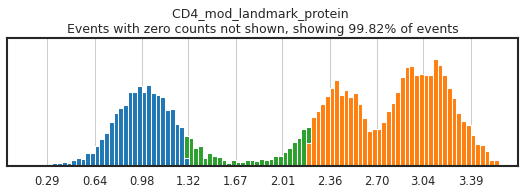

FloatSlider(value=2.2, layout=Layout(width='600px'), max=3.7295516974970893)

FloatSlider(value=1.3000000000000005, layout=Layout(width='600px'), max=3.7295516974970893)

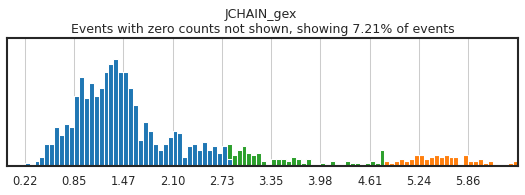

FloatSlider(value=4.8, layout=Layout(width='600px'), max=6.490779399871826)

FloatSlider(value=2.8, layout=Layout(width='600px'), max=6.490779399871826)

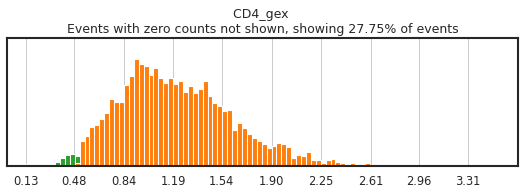

FloatSlider(value=0.4999999999999999, layout=Layout(width='600px'), max=3.6660006046295166)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=3.6660006046295166)

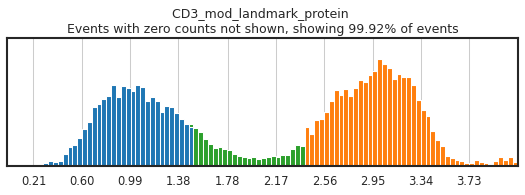

FloatSlider(value=2.4, layout=Layout(width='600px'), max=4.120174659562347)

FloatSlider(value=1.5, layout=Layout(width='600px'), max=4.120174659562347)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [22]:
h.run_all_thresholds(adata, mode='fancy rerun all', limit=['JCHAIN','CD4','CD4_gex','CD3'])

<div class="alert alert-info">
<b>Tip: Choosing optimal thresholds</b> 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Carefully gating your populations can greatly improve the training data, and thus classification, but figuring out how gates need to be adjusted can be tricky! On cleanly bimodal markers, you want to include cells that are clearly in the positive and negative distributions, leaving events with middling expression undefined. Be careful not to be too stringent though, as limiting calls to only the most extreme positive and negative events may inadvertently train the classifier on only a subset of the cell lineage, or on only the highest quality of data, neither of which would produce effective classification.
</div>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Be sure to save your thresholds to a .csv, as these will be useful as you iteratively train the classifier to fine-tune population identification. This save function allows for non-destructive updates to a file, replacing only the markers that you define each run — so if you remove a marker temporarily from the hierarchy, those carefully defined thresholds won't be lost!

In [23]:
h.save_thresholds(f'data/integrated_thresholds.csv')

Saving non-destructively...


## **Train and run the classifier**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It's finally time to train the classifier. The classify function works its way down the hierarchy, identifying high-confidence populations using our predefined thresholds, training a RandomForestClassifier, storing that classifier back in the hierarchy, and using that classifier to predict cell subsets at that level. This process is repeated until all cells receive their terminal annotation label. Future runs of the classify function with `retrain=False` will be able to use those classifier objects to predict cell types without retraining. See the [Pretrained Classification tutorial](./Pretrained_Classification.ipynb) for more details.

In [24]:
adata, hierarchy = mmc.classify(adata, h.copy(), 'lin', 'landmark_protein', retrain=True, weight_integration=True) 

Setting up...
Using .X and landmark_protein


Removing 18757 features lacking expression in a minimum of 25 events...
Resorting to enforce sorted order of features by name


Set up complete.
Using 14795 features


Running with batch batch
Using weights of: [0.4001677852348993, 0.5998322147651006] for random forest n_estimators


Data subsetted on All in All
Running high-confidence populations for Removal...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Performing cutoff for Removal...
Merging data into adata.obsm['lin']
Predicted:
To classify           13035
Potential Doublets       77
Name: Removal_class, dtype: int64
Data subsetted on To classify in Removal
Running high-confidence populations for Broad Lineages...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for Broad Lineages...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'Lymphocyte': 1.1632278397822295, 'Myelocyte': 1.9575665682936332}


Initializing classifier for Broad Lineages...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


3458 real cells in training set...


Resampling...


/home/ubuntu/miniconda3/envs/mmochi/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/mmochi/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/mmochi/lib/python3.8/site-packages/umap/d

Training with 4978 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.3s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


4605 real cells in training set...


Resampling...


Found: 128 noise and 0 in danger of 4605 events.


Training with 6776 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Running calibration on random forest


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic


Predicting for Broad Lineages...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Predicted:
Lymphocyte    9204
Myelocyte     3831
Name: Broad Lineages_class, dtype: int64
Data subsetted on Lymphocyte in Broad Lineages
Running high-confidence populations for Lymphoid...


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.5s finished
Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for Lymphoid...


Checking subsets for minimum events...
Spiking in 14 of Plasma cell in 5k_pbmc_protein_v3 to reach 15 events
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'B cell': 3.141153900414139, 'NK_ILC': 2.406463916318353, 'Plasma cell': 12.300067750490918, 'T cell': 1.1790345675532383}


Initializing classifier for Lymphoid...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


2293 real cells in training set...


Resampling...


Found: 15 noise and 11 in danger of 2293 events.


Training with 7068 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.4s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


3538 real cells in training set...


Resampling...


Found: 10 noise and 7 in danger of 3538 events.


Training with 9776 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s


Merging data into adata.obsm['lin']
Running calibration on random forest


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


Predicting for Lymphoid...


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Predicted:
T cell         6700
NK_ILC         1533
B cell          885
Plasma cell      86
Name: Lymphoid_class, dtype: int64
Data subsetted on NK_ILC in Lymphoid
Running high-confidence populations for NK_ILC Subsets...


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.3s finished
Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for NK_ILC Subsets...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'ILC': 2.4462982238476156, 'NK': 1.0957312440775104}


Initializing classifier for NK_ILC Subsets...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


103 real cells in training set...


Resampling...


Found: 4 noise and 6 in danger of 103 events.


Training with 176 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.0s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


209 real cells in training set...


Resampling...


Found: 2 noise and 7 in danger of 209 events.


Training with 366 events after oversample resampling...
Merging data into adata.obsm['lin']
Running calibration on random forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic


Predicting for NK_ILC Subsets...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished


Merging data into adata.obsm['lin']
Predicted:
NK     1211
ILC     322
Name: NK_ILC Subsets_class, dtype: int64
Data subsetted on T cell in Lymphoid
Running high-confidence populations for CD4_CD8...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for CD4_CD8...


Checking subsets for minimum events...
{'max_features': 0.1, 'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'CD4 T cell': 1.0935303547449053, 'CD8 T cell': 2.4712399776280383}


Initializing classifier for CD4_CD8...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


2041 real cells in training set...


Resampling...


Found: 30 noise and 43 in danger of 2041 events.


Training with 3764 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.5s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


2503 real cells in training set...


Resampling...


Found: 41 noise and 24 in danger of 2503 events.


Training with 3928 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s


Merging data into adata.obsm['lin']
Running calibration on random forest


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic


Predicting for CD4_CD8...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Predicted:
CD4 T cell    5077
CD8 T cell    1623
Name: CD4_CD8_class, dtype: int64


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.2s finished
Converting columns in adata.obsm["lin"] to savable dtypes...


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Classification information for each cell is stored by default in a DataFrame in the `.obsm['lin']`. This includes information for each classification level on whether a cell was identified by the high-confidence thresholding, whether it was set aside as training data, how many times it was represented in the training data (both oversampling and the `in_danger_noise checker` can overrepresent events in the training dataset), its probability identification, and its ultimate classification. More details on the format of this DataFrame are listed in the [Input/Output Specifications](Input_Output_Specs.md).

In [25]:
adata.obsm['lin']

,All_class,Removal_hc,Removal_class,Broad Lineages_hc,Broad Lineages_hold_out,Broad Lineages_traincounts,Broad Lineages_train,Broad Lineages_probability,Broad Lineages_class,Lymphoid_hc,...,NK_ILC Subsets_traincounts,NK_ILC Subsets_train,NK_ILC Subsets_probability,NK_ILC Subsets_class,CD4_CD8_hc,CD4_CD8_hold_out,CD4_CD8_traincounts,CD4_CD8_train,CD4_CD8_probability,CD4_CD8_class
MMoCHi_obs_names,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATTGTGA-1_pbmc_10k_protein_v3,All,To classify,To classify,?,True,0.0,False,1.000000,Myelocyte,nan,...,0.0,False,NaN,nan,nan,False,0.0,False,NaN,nan
AAACCCACATCGGTTA-1_pbmc_10k_protein_v3,All,To classify,To classify,?,True,0.0,False,1.000000,Myelocyte,nan,...,0.0,False,NaN,nan,nan,False,0.0,False,NaN,nan
AAACCCAGTACCGCGT-1_pbmc_10k_protein_v3,All,To classify,To classify,Myelocyte,False,4.0,True,1.000000,Myelocyte,nan,...,0.0,False,NaN,nan,nan,False,0.0,False,NaN,nan
AAACCCAGTATCGAAA-1_pbmc_10k_protein_v3,All,To classify,To classify,?,True,0.0,False,0.931818,Lymphocyte,NK_ILC,...,0.0,False,0.5,ILC,nan,False,0.0,False,NaN,nan
AAACCCAGTCGTCATA-1_pbmc_10k_protein_v3,All,To classify,To classify,?,True,0.0,False,1.000000,Lymphocyte,NK_ILC,...,0.0,False,1.0,NK,nan,False,0.0,False,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCACAAG-1_5k_pbmc_protein_v3,All,To classify,To classify,Lymphocyte,True,0.0,False,1.000000,Lymphocyte,?,...,0.0,False,NaN,nan,CD8 T cell,False,5.0,True,1.000000,CD8 T cell
TTTGTTGCAGTCTTCC-1_5k_pbmc_protein_v3,All,To classify,To classify,Lymphocyte,False,1.0,True,1.000000,Lymphocyte,T cell,...,0.0,False,NaN,nan,CD4 T cell,True,0.0,False,1.000000,CD4 T cell
TTTGTTGCATGGCCCA-1_5k_pbmc_protein_v3,All,To classify,To classify,?,True,0.0,False,1.000000,Lymphocyte,T cell,...,0.0,False,NaN,nan,?,True,0.0,False,0.647887,CD8 T cell


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Immediately after classification, you may be interested in identifying cells by their deepest level of classification. This function will add columns to the `.obs` for the classification and probability of each call. Note, these certainty values only reflect the percent of the forest in agreement with the terminal cell call, not classifications of its intermediate subsets.

In [26]:
adata = mmc.terminal_names(adata)

<div class="alert alert-info">

**Tip — Cleaning classifications**
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have found that MMoCHi works best when applying classifications to individual cells. If, however, you expect clustering to perform well at separating cell types, with only a few mixed clusters, you could try majority voting! Pass a <code>voting_reference</code> column in the <code>.obs</code>, along with a <code>majority_min</code> to define the minimum majority for a cluster to be called a single cell type. </div>

## **Save and load your model!**

The AnnData can be saved to store classification results and Hierachy object can be saved as a .hierarchy file for future classification or evaluation.

In [27]:
adata.write(f'data/classified_events.h5ad') 
hierarchy.save(f'data/IntegratedClassifier')

... storing 'T_B doublets' as categorical


To load the hierarchy, just specify the file name (without the `.hierarchy`) during object creation

In [28]:
hierarchy = mmc.Hierarchy(load=f'data/IntegratedClassifier')
adata = anndata.read_h5ad(f'data/classified_events.h5ad')

Loading classifier from data/IntegratedClassifier...


Loaded data/IntegratedClassifier.hierarchy


## **Evaluate the classifier's performance**

Once you've run MMoCHi classification, you might be wondering how accurate those classifications are. Here are some ways we can investigate that!
    
#### Do classifications align with expected marker expression?
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The first (and most important) evaluation of classification performance is whether classified populations express expected marker genes and proteins. The MMoCHi classifications should reflect the known markers that were used in high-confidence thresholding, as well as other known cell type markers. We can inspect the classifications using the UMAP and markers from before:

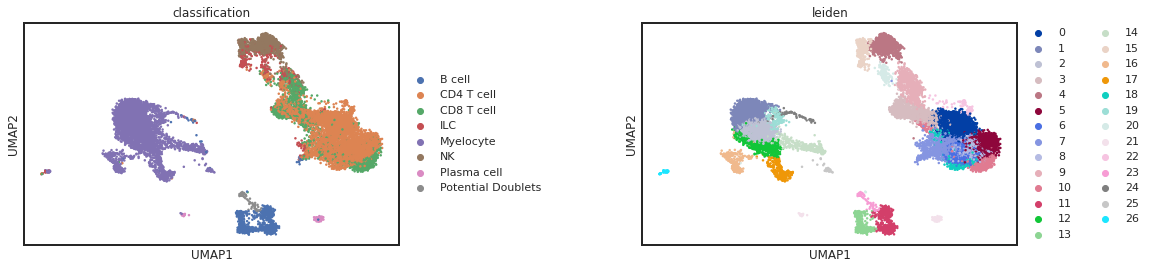

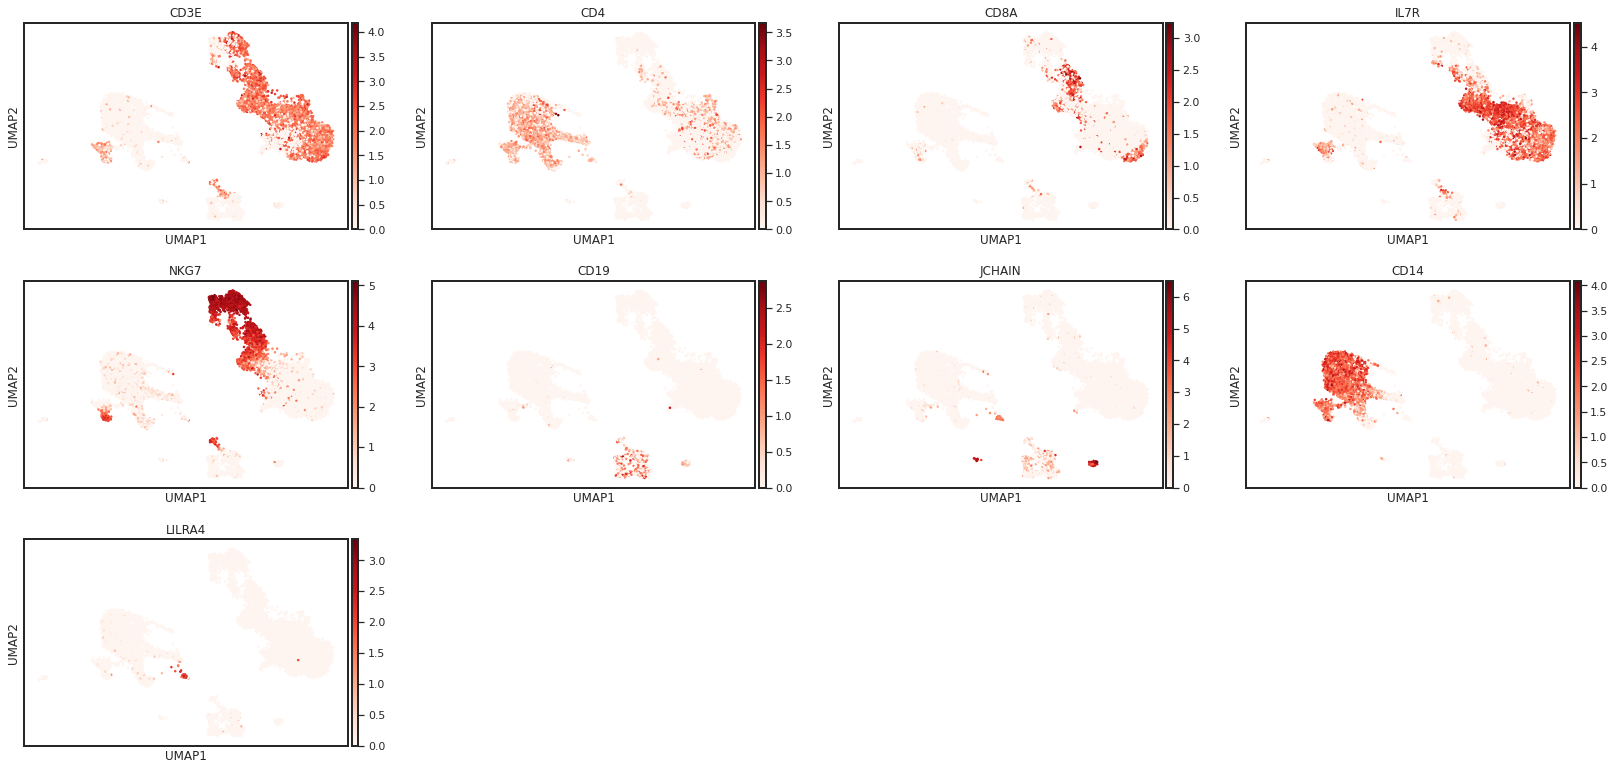

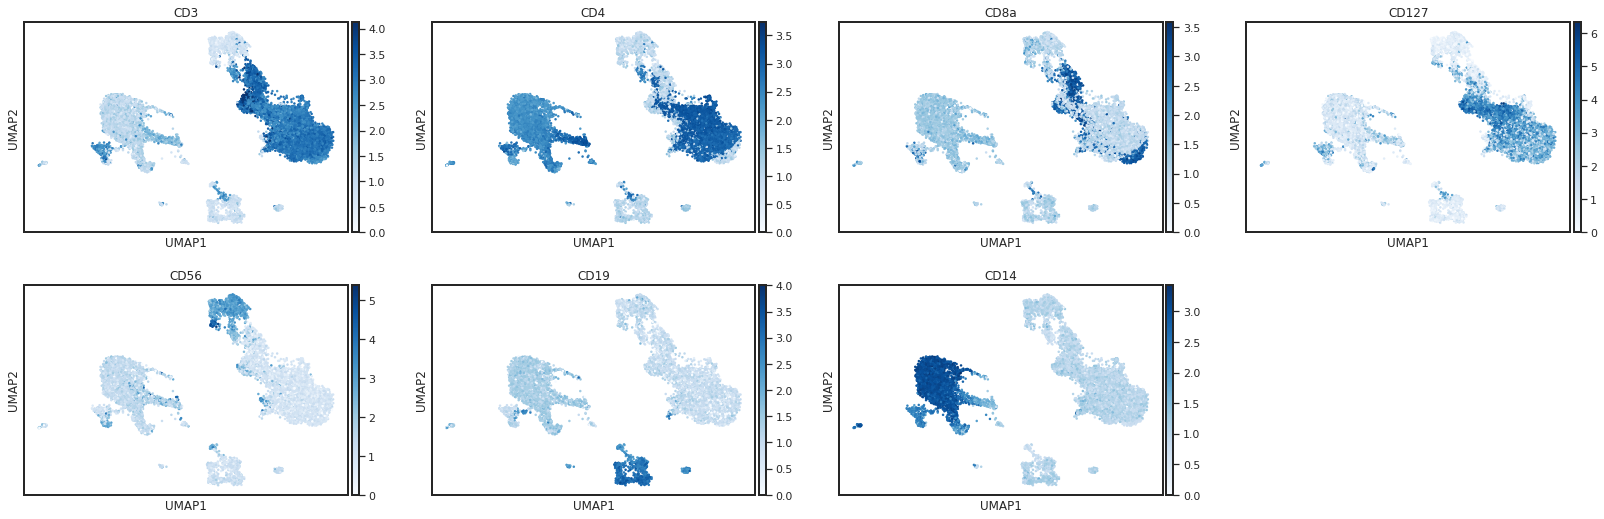

In [29]:
sc.pl.umap(adata, color=['classification','leiden'], s=25, sort_order=False, wspace=.5)
sc.pl.umap(adata, color=['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14','LILRA4'], s=25, sort_order=False, cmap='Reds')
sc.pl.umap(protein_adata, color=['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'], s=25, sort_order=False, cmap='Blues')

We can also look at marker expression using dotplots for GEX and violin plots for ADTs. This is great for populations that segregate poorly on the UMAP and can help to identify outliers.

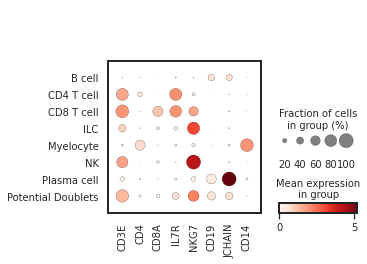

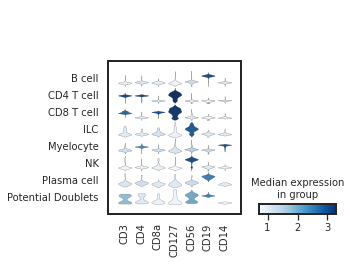

In [30]:
sc.pl.dotplot(adata, ['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'], 'classification')
protein_adata.obs['classification'] = adata.obs.classification
sc.pl.stacked_violin(protein_adata, ['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'], 'classification')

<div class="alert alert-info">

**Tip — Classifier Troubleshooting**
    
If classified subsets do not align to known markers, you will need to troubleshoot! The most common steps to troubleshoot are:
1. High-confidence thresholding — Did you capture a relevant selection? See the [High-Confidence Thresholding tutorial](./High_Confidence_Thresholding.ipynb) for more details.
2. Training data cleanup and resampling — Are the high-confidence events well represented in training data? Alternative methods for cleanup and resampling are described in `mmc.classifier._balance_training_classes`. Note, alternative resampling methods are experimental.
3. Fitness of random forests — The confusion matrices we will plot below may reveal random forests are poorly fit. This can be altered by passing various kwargs to the random forests in the hierarchy (see above for details) or by redesigning the hierarchy. 
4. Class imbalance — High imbalance between event numbers across subsets in one classification level may lead to poor classification performance, which is often revealed by sigmoidal-calibration plots. Consider altering classifier kwargs or redesigning the hierarchy to reduce/isolate this imbalance (imbalances tend to classify better in binary classification levels).
5. Learned representation — Are random forests learning the correct representation of the cell types? This question is explored in the [Exploring Feature Importances tutorial](./Exploring_Feature_Importances.ipynb), and these issues are best resolved by redesigning the hierarchy or changing feature inputs to isolate confounding variation. 
    
The plotting functions below can assist with identifying issues in classifier performance.
</div>

#### How consistent is the classifier at predicting the high-confidence data?
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Confusion matrices show the performance of the trained random forest on held-out data. Held-out data is data that is not used for training, thus revealing performance on previously "unseen" data. Metrics calculated from this (Precision, Recall, F1) are a useful internal control to explain how well the random forests are performing. Cells on the diagonal are correctly called.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Note that although a 20% holdout is created when training each batch, spike-ins of rare classes across batches for training can violate that 20% holdout. The `mmc.classify()` parameter `enforce_hold_out` should be enabled solve this by introducing an extra 10% holdout, but it may reduce the total amount of events available for training. Regardless, exercise caution when interpreting confusion matrices if any column or row sums to 0, as F1, Precision, and Recall values will be invalid.

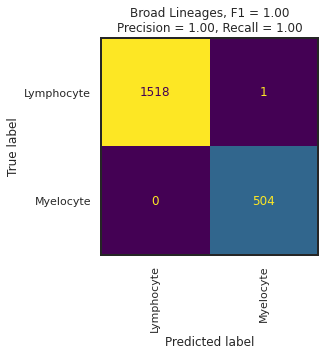

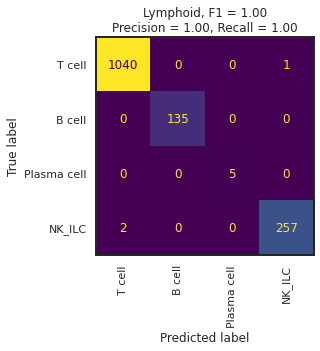

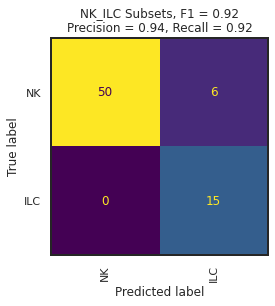

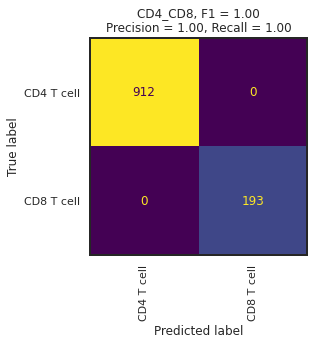

In [31]:
mmc.plot_confusion(adata, 'All', hierarchy, show=True, holdout_only=True, save='data/Confusion_plots.pdf')

#### How reliable are confidence scores at any given level?
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calibration plots compare the proportion of samples correctly classified for each subset to the classifier's outputted probability. Ideally, these curves fit the 45-degree line, which would suggest the probability/certainty score is reliable. If this line is wildly off (e.g. sigmoidal) it may suggest there are issues with class imbalance that need to be addressed. 

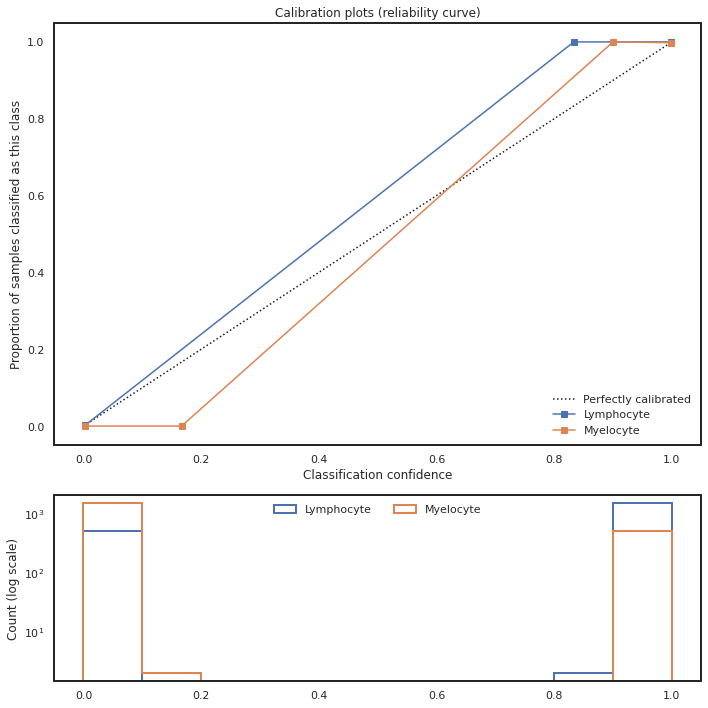

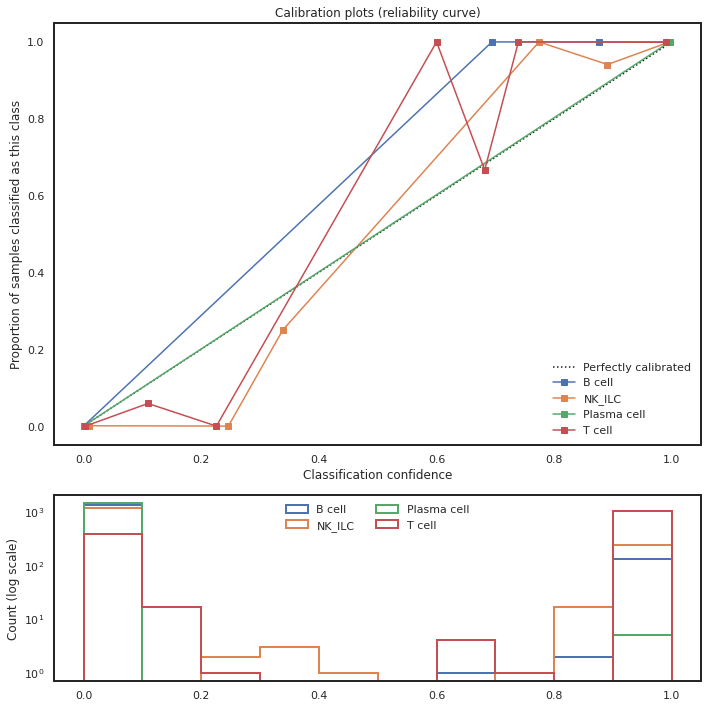

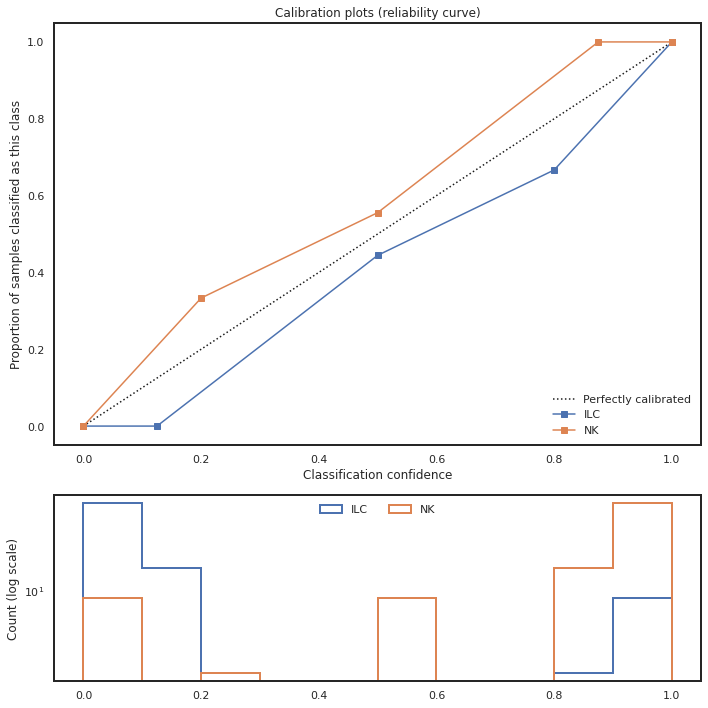

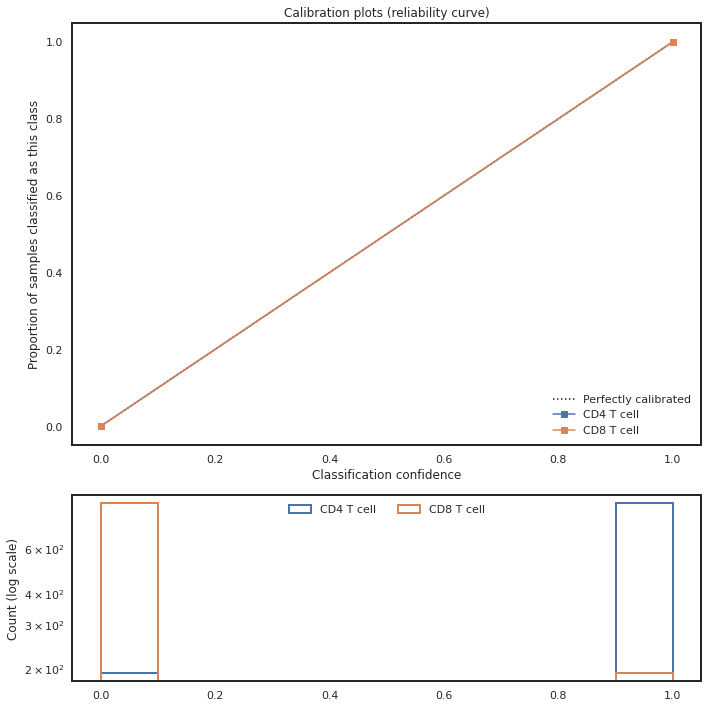

In [32]:
mmc.plot_confidence(adata, 'All', hierarchy, show=True, holdout_only=True, save='data/Confusion_plots.pdf')

#### Which events were used for training?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lastly, it may help to directly investigate on the UMAP which cells used for training and which were miscalled. For this, we can use a simple helper function which plots information from the `.obsm['lin']` for a given level. In this example, we can clearly see that NK cells were not included in the Lymphocyte high-confidence thresholding, but luckily were annotated correctly. If there had been issues with classification, we would want to identify better markers for high-confidence thresholding to identify NK cells as Lymphocytes.

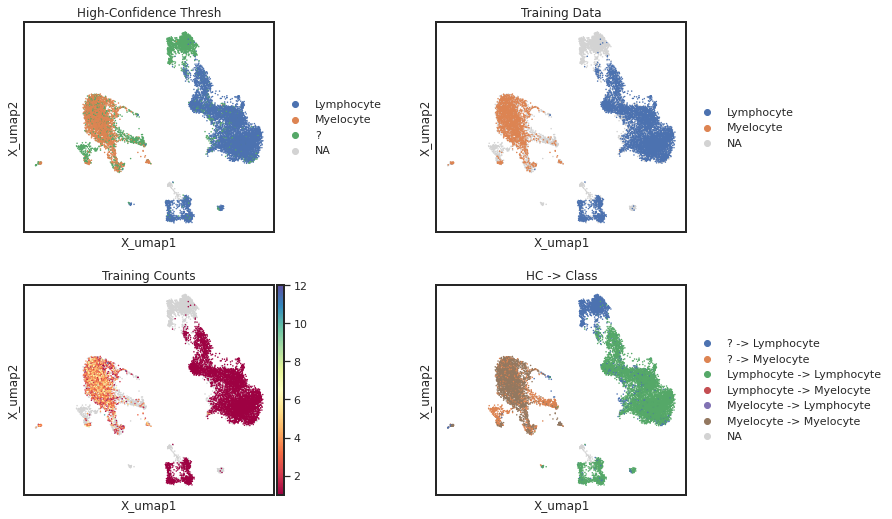

In [33]:
with plt.rc_context({'figure.figsize':(4,4)}):
    mmc.utils.umap_interrogate_level(adata, 'Broad Lineages', cmap='Spectral', wspace=.5)

This relationship can be better highlighted by using the `groups` kwarg for `sc.pl.embedding`

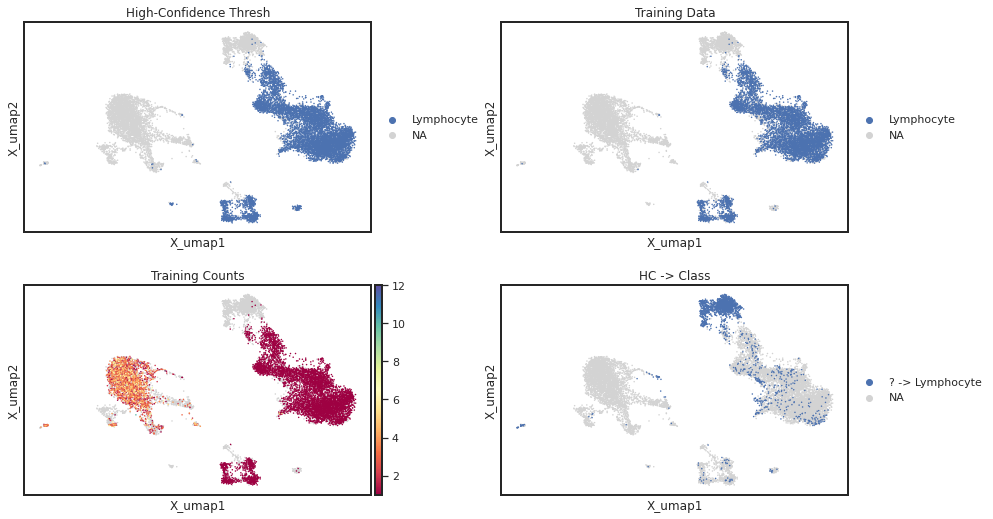

In [34]:
mmc.utils.umap_interrogate_level(adata, 'Broad Lineages', cmap='Spectral', groups=['Lymphocyte','? -> Lymphocyte'], wspace=.25)

### Great! Now your annotated cells are ready for downstream analysis

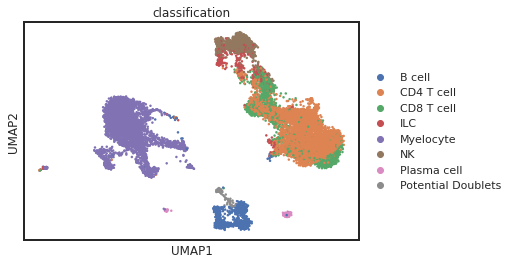

In [35]:
sc.pl.umap(adata, color=['classification'], s=25, sort_order=False, wspace=.5)

<div class="alert alert-success">

**Congratulations!** 
    
You've completed your first tutorial with MMoCHi!
</div>